In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import string
import re
import scipy.sparse as sp
from collections import Counter, defaultdict

import torch 
import torch.nn as nn
import torch.optim as optim 
from tqdm import tqdm
import random

from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

### Part1: Representing Text Data

In [5]:
train = pd.read_csv('train.csv')   
train.head()    

,text,par_id,label
0,"We 're living in times of absolute insanity , ...",1,0
1,"In Libya today , there are countless number of...",2,0
2,White House press secretary Sean Spicer said t...,3,0
3,Council customers only signs would be displaye...,4,0
4,""" Just like we received migrants fleeing El Sa...",5,0


In [6]:
label1_index = []
label0_index = []
for i in range(len(train)):
    if train['label'][i] == 1:
        label1_index.append(i)
    else:
        label0_index.append(i)

In [7]:
label0_index[:20]
label1_index[:10]

[32, 33, 41, 76, 82, 106, 117, 148, 150, 151]

#### 1.1 Tokenize

In [8]:
def tokenize(text):
    return(text.split())    


# Refer to https://pythonprogramming.net/stop-words-nltk-tutorial/
stop_words = ['ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than']


def better_tokenize(text):
    text = str(text)
    text = text.lower().replace('\n', ' ').replace('\r', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation + '0123456789'))
    text = re.sub(r'<[^<>]*>', '', text) 
    tokens = text.split()
    tokens = [token for token in tokens if (token not in stop_words and len(token) > 2)] 
    return(tokens)

#### 1.2 Building the Term-Document Matrix

In [9]:
# def to_sparse_tensor(sp_matrix):
#     sp_matrix = sp_matrix.tocoo()
#     indices = torch.LongTensor(np.vstack((sp_matrix.row, sp_matrix.col)))
#     val = torch.FloatTensor(sp_matrix.data)
#     shape = torch.Size(sp_matrix.shape)
#     return torch.sparse_coo_tensor(indices, val, shape)  


# Create term-document matrix
def td_matrix(file, minimun_frequency=2, if_better_tokenize=True): 
    sparse_matrix = defaultdict(Counter)
    doc = pd.read_csv(file)
    for idx, line in enumerate(doc['text']):
        if if_better_tokenize:
            tokens = better_tokenize(line)
        else:
            tokens = tokenize(line)
        terms_count = Counter(tokens)   
        for term, count in terms_count.items():
                sparse_matrix[term][idx] += count  
          
            
    # Remove terms below the minimun frequency
    mf_sparse_matrix = defaultdict(Counter)
    for term in sparse_matrix.keys():
        if sum(sparse_matrix[term].values()) >= minimun_frequency:
            mf_sparse_matrix[term] = sparse_matrix[term]
    words_dict = mf_sparse_matrix.keys()   
    
    # Create a numpy and SciPy matrix
    n = doc.shape[0]
    m = len(words_dict)
    matrix = np.zeros((n, m), dtype=int)
    for idx, term in enumerate(words_dict):
        for doc_idx, count in mf_sparse_matrix[term].items():
            matrix[doc_idx][idx] = count
            
    sparse_matrix_SciPy = sp.csr_matrix(matrix)
    
    train_label_tensor_matrix = np.array(doc['label'])
    
    return words_dict, sparse_matrix_SciPy, train_label_tensor_matrix

def dd_matrix(file, words_dict, if_better_tokenize=True):
    doc = pd.read_csv(file)
    # Create a numpy and SciPy matrix
    n = doc.shape[0]
    m = len(words_dict)
    matrix = np.zeros((n, m), dtype=int)
    words_dict = [x for x in words_dict]
    
    for idx, line in enumerate(doc['text']):
        # if idx % 100 == 0:
        #     print("Processing: ", idx)
        if if_better_tokenize:
            tokens = better_tokenize(line)
        else:
            tokens = tokenize(line) 
        terms_count = Counter(tokens)   
        for term, count in terms_count.items():
            for i in range(len(words_dict)):
                if term == words_dict[i]:
                    matrix[idx][i] += count
                    
    dev_sparse_matrix_SciPy = sp.csr_matrix(matrix)
    
    if 'label' in doc.columns:  
        dev_label_tensor_matrix = np.array(doc['label'])
        return dev_sparse_matrix_SciPy, dev_label_tensor_matrix
    else:
        return dev_sparse_matrix_SciPy

#### Part 2: Logistic Regression: Numpy

#### 1.1 Function

In [88]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def log_likelihood(X, Y, parameters): 
    ll = 0
    X_array = X.toarray()
    for i in range(X.shape[0]):
        ll += Y[i] * np.dot(parameters, X_array[i]) - np.log10(1 + np.exp(np.dot(parameters, X_array[i])))
    return ll

def compute_gradient(x, y, parameters):
    return (sigmoid(np.dot(parameters, x))-y)*x

class logisticRegression():
    def __init__(self, in_dim, lr=2e-2, epochs=1, num_steps=50, total_steps=1000):
        self.lr=lr
        self.epochs=epochs  
        self.num_steps=num_steps    
        self.total_steps=total_steps    
        self.step_list = []
        self.f1_scores = []
        self.ll_list = []
        self.parameters = np.zeros(in_dim)
        
    def train_model(self, X, Y, X_dev, Y_dev):
        current_step = 0
        total_steps = self.total_steps
        patch_order = []
        X_array = X.toarray()
        X_dev = X_dev.toarray()
        for i in range(0, total_steps, 3):
            patch_order += self.pack_patches(label0_index, label1_index)
            
        for epoch in range(self.epochs):
            current_step = 0
            print("Epoch: ", epoch)
            while(current_step < total_steps):
                for j in tqdm(range(len(patch_order))):
                    idx = patch_order[j]
                    current_step += 1
                    x = X_array[idx]
                    y = Y[idx]
                    gradient = compute_gradient(x, y, self.parameters)
                    self.parameters -= self.lr * gradient
                    if current_step % self.num_steps == 0:
                        self.step_list.append((len(self.ll_list)+1)*self.num_steps)
                        self.f1_scores.append(f1_score(sigmoid(np.dot(self.parameters,X_dev.T)).round(), Y_dev))
                        self.ll_list.append(log_likelihood(X, Y, self.parameters))
                        
    # create patch of size-3 or 5  
    # which contain two/ three indexes of label0 and one/two index of label1                  
    def pack_patches(self, label0_index, label1_index): 
        patches = []
        # patches.append(random.choice(label0_index))
        patches.append(random.choice(label0_index))
        patches.append(random.choice(label0_index))
        patches.append(random.choice(label1_index))  
        # patches.append(random.choice(label1_index)) 
        np.random.shuffle(patches)
        return patches
        
    def predict(self, X_test):
        X_test = X_test.toarray()   
        return sigmoid(np.dot(self.parameters, X_test.T)).round()   
    
    

In [11]:
word_dict, X, Y = td_matrix('train.csv', minimun_frequency=2, if_better_tokenize=True)


In [15]:
X_dev, Y_dev = dd_matrix('dev.csv', word_dict, if_better_tokenize=True)

#### 1.2 Test Model If Work

In [62]:
numpy_model1 = logisticRegression(in_dim=len(word_dict), lr=2e-2, epochs=1, num_steps=20, total_steps=1000)

In [63]:
numpy_model1.train_model(X, Y, X_dev, Y_dev)

Epoch:  0


100%|██████████| 1002/1002 [00:20<00:00, 50.08it/s]


Text(0.5, 1.0, 'Log likelyhood vs. Steps: lr=2e-2, epochs=1, num_steps=20, total_steps=1000')

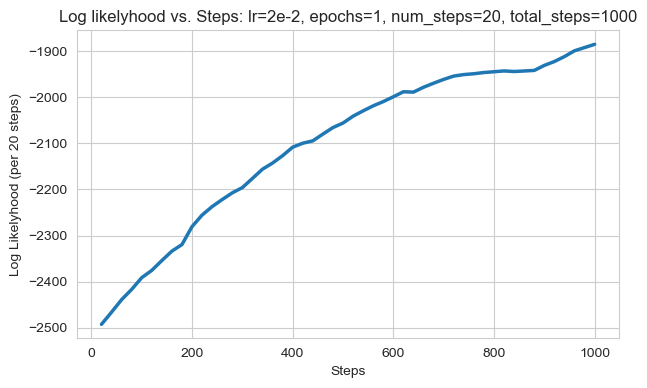

In [64]:
plt.figure(figsize=(7, 4))
sns.lineplot(x=numpy_model1.step_list, y=numpy_model1.ll_list, linewidth=2.5)
plt.xlabel("Steps")
plt.ylabel("Log Likelyhood (per 20 steps)")
plt.title("Log likelyhood vs. Steps: lr=2e-2, epochs=1, num_steps=20, total_steps=1000")

Epoch:  0


100%|██████████| 8376/8376 [00:55<00:00, 149.63it/s]


Epoch:  1


100%|██████████| 8376/8376 [00:59<00:00, 139.77it/s]


Epoch:  2


100%|██████████| 8376/8376 [00:59<00:00, 141.34it/s]


Epoch:  3


100%|██████████| 8376/8376 [00:57<00:00, 146.89it/s]


Epoch:  4


100%|██████████| 8376/8376 [00:54<00:00, 152.62it/s]


Text(0.5, 1.0, 'Log likelyhood vs. Steps: lr=2e-2, epochs=5, num_steps=50, total_steps=whole')

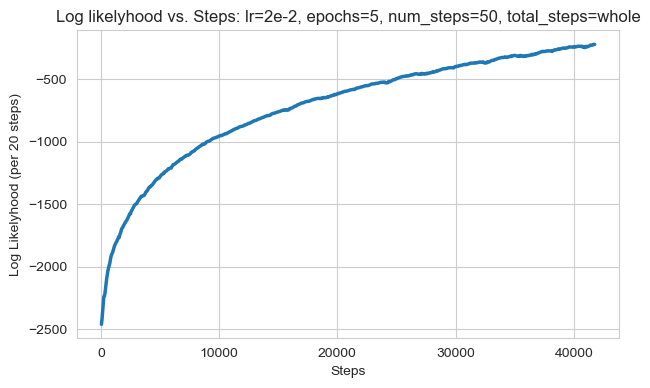

In [100]:
numpy_model2 = logisticRegression(in_dim=len(word_dict), lr=2e-2, epochs=5, num_steps=50, total_steps=X.shape[0])
numpy_model2.train_model(X, Y, X_dev, Y_dev)
plt.figure(figsize=(7, 4))
sns.lineplot(x=numpy_model2.step_list, y=numpy_model2.ll_list, linewidth=2.5)
plt.xlabel("Steps")
plt.ylabel("Log Likelyhood (per 20 steps)")
plt.title("Log likelyhood vs. Steps: lr=2e-2, epochs=5, num_steps=50, total_steps=whole")

Text(0.5, 1.0, 'F1 score vs. Steps')

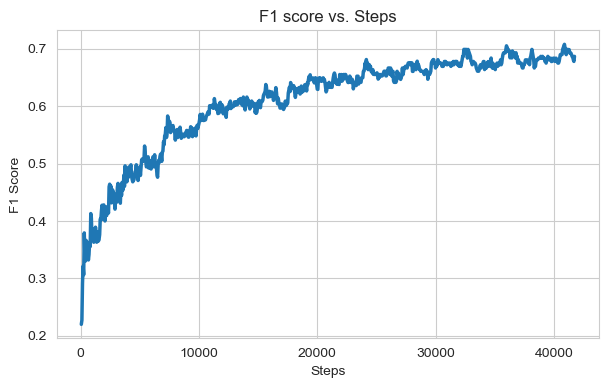

In [101]:
plt.figure(figsize=(7, 4))
sns.lineplot(x=numpy_model2.step_list, y=numpy_model2.f1_scores, linewidth=2.5)
plt.xlabel("Steps")
plt.ylabel("F1 Score")
plt.title("F1 score vs. Steps")

#### 2.3 Export the final data

In [98]:
X_final = dd_matrix("test.student.csv", word_dict)

In [99]:
y_final = numpy_model2.predict(X_final)
pair_id = pd.read_csv('test.student.csv')['par_id']
with torch.no_grad():
    final_df = pd.DataFrame({'par_id': pair_id, 'label': y_final}) 
final_df.to_csv('test.student.predicted.numpy.csv', index=False)